#### Hi
this will be a CIFAR10 using VGG16 (pre trained model)  
My model (hand made) (the previous one) had 82.2% of accuracy.   
Lets see how this VGG16 will do  

2023/01/30 2027i let get init  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
import sys

In [3]:
#GPU
import torch

if torch.cuda.is_available():
    device = 'cuda'
    device_count = torch.cuda.device_count()
    if device_count > 1:
        # GPU's
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working: ", end="")
        print(templist.is_cuda)
        print("GPU device count: ", end="")
        print(device_count)
        for i in range(device_count):
            print("GPU name {}: {}".format(i, torch.cuda.get_device_name(i)))
        print("current device no.: ", end="")
        print(torch.cuda.current_device())
    else:
        # A GPU
        print("Cuda torch working: ", end="")
        print(torch.cuda.is_available())
        print("GPU device count: ", end="")
        print(device_count)
        print("GPU name: ", end="")
        print(torch.cuda.get_device_name(0))
        print("current device no.: ", end="")
        print(torch.cuda.current_device())
else:
    if torch.backends.mps.is_available():
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("Cannot use GPU, activating CPU")
        device = 'cpu'


Cuda torch working: True
GPU device count: 1
GPU name: NVIDIA GeForce GTX 1080
current device no.: 0


#### Data
since the VGG16 uses 224 x 224 model and CIFAR10 is 32x32 we have to change the CIFAR10 size to 224x224  

In [4]:
from torchvision import models

num_subprocesses = 8 ###CHANGE (REDUCE) VALUE IF ERROR (its about GPU memroy)###
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                        shuffle=True, num_workers=num_subprocesses)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                        shuffle=False, num_workers=num_subprocesses)


Files already downloaded and verified
Files already downloaded and verified


#### VGG
I will use the predtrained vgg  
The default out features of vgg16 is 1000. But we need only one.  
So we will need line no 5. to change the out features to 10  
And since we will not change the parameters we will not require grad  
  


In [5]:
vgg16 = models.vgg16(pretrained=True)

# if multiple GPUs are available, wrap model with DataParallel 
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    vgg16 = nn.DataParallel(vgg16)

vgg16.to(device)


# change the number of classes 
vgg16.classifier[6].out_features = 10

# freeze convolution weights
# BUT convolutional layers WILL learn // allowing the model to focus on learning the mapping between the extracted features and the output predictions
for param in vgg16.features.parameters():
    param.requires_grad = False

c:\ProgramData\Anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\torchenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### LOSS and Optim


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

In [7]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [8]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [9]:
### Do you want to skip leanring or not?
### Set SKIP to 1 if you want to skip leaning 

SKIP = 1
NB_EPOCH = 10

if (SKIP == 0):

    # Set the initial best validation accuracy to 0
    best_val_accuracy = 0.0

    # Initialize the best model state dictionary
    best_model_state_dict = None

    train_loss , train_accuracy = [], []
    val_loss , val_accuracy = [], []
    start = time.time()
    for epoch in range(NB_EPOCH):
        train_epoch_loss, train_epoch_accuracy = train(vgg16, trainloader)
        val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
        print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)
            # Check if the current validation accuracy is better than the previous best
        if val_epoch_accuracy > best_val_accuracy:
            # Update the best validation accuracy
            best_val_accuracy = val_epoch_accuracy

            # Save the state dictionary of the current best model
            best_model_state_dict = vgg16.state_dict()


            
    # Save the best model state dictionary to a file
    torch.save(best_model_state_dict, "vgg16CIFAR.pth")
        
    end = time.time()

    print(int((end-start)//60), 'minutes', int((end-start)%60), 'seconds')
else:
    print("skip")

skip


In [10]:
loaded_data = torch.load('vgg16CIFAR.pth')

# If the loaded data is a model state dictionary, it should be a python dictionary
print(type(loaded_data))

<class 'collections.OrderedDict'>


In [11]:
## Time

import time

def format_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    if hours > 0:
        return f"{int(hours)}h {int(minutes)}m {seconds:.2f}s"
    elif minutes > 0:
        return f"{int(minutes)}m {seconds:.2f}s"
    else:
        return f"{seconds:.2f}s"

# Kaggle files

To unzip


In [12]:
import py7zr
import os

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    # Running on Kaggle
    file_path = "/kaggle/input/cifar-10/test.7z"
    output_path = "/kaggle/working/test/test/"
    print("Running on Kaggle")
else:
    # Running on local machine
    file_path = ".test.7z"  # change to your local file path
    output_path = "./test/"  # change to your desired output path
    print("Running on local machine")

# Check if output directory exists
if not os.path.exists(output_path):
    print("Output directory does not exist. Creating directory and extracting files...")
    # Directory does not exist, extract files
    os.makedirs(output_path, exist_ok=True)
    with py7zr.SevenZipFile(file_path, mode='r') as z:
        z.extractall(output_path)
else:
    # Directory exists, check if it's empty
    if not os.listdir(output_path):
        print("Output directory exists but is empty. Extracting files...")
        # Directory is empty, extract files
        with py7zr.SevenZipFile(file_path, mode='r') as z:
            z.extractall(output_path)
    else:
        print("Output directory exists and is not empty. No extraction needed.")


Running on local machine
Output directory exists and is not empty. No extraction needed.


Time for how much ETA

# Load model

In [13]:

device = 'cuda'
#device = 'mps'

try:
    # Load the pre-trained weights
    model_checkpoint = "vgg16CIFAR.pth"
    vgg16.load_state_dict(torch.load(model_checkpoint))

    # Make sure to do this before inference
    vgg16.eval()
    vgg16.to(device)
    print("model loaded")
    
except NameError:
    from torchvision import models
    import torch
    print("No training, loading vgg16 bset vgg16 model")
    vgg16 = models.vgg16(weights='imagenet')
    # if multiple GPUs are available, wrap model with DataParallel 
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs")
        vgg16 = nn.DataParallel(vgg16)
    vgg16.to(device)
    # change the number of classes 
    vgg16.classifier[6].out_features = 10
    # freeze convolution weights
    # BUT convolutional layers WILL learn // allowing the model to focus on learning the mapping between the extracted features and the output predictions
    for param in vgg16.features.parameters():
        param.requires_grad = False
    # Load the pre-trained weights
    model_checkpoint = "vgg16CIFAR.pth"
    vgg16.load_state_dict(torch.load(model_checkpoint))
    # Make sure to do this before inference
    vgg16.eval()
    vgg16.to(device)
    print("Model loaded")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")


#print(vgg16)

model loaded


# Load path

In [14]:
# Path to your new images
image_path = output_path + "test/"
image_files = os.listdir(image_path)
print("Loaded path")

Loaded path


# Image inspection 300,000

In [15]:
import sys

# Path to your new images
image_path = output_path + "test"
image_files = os.listdir(image_path)
print("Loaded path")

# Get the number of image files
num_images = len(image_files)

# Check if the image count is 300000
if num_images != 300000:
    print(f"Error: The number of images (files) is {num_images}, not 300,000. Please check the dataset.")
    sys.exit(0)
else:
    print(f"Number of images is correct: {num_images}")


Loaded path
Number of images is correct: 300000


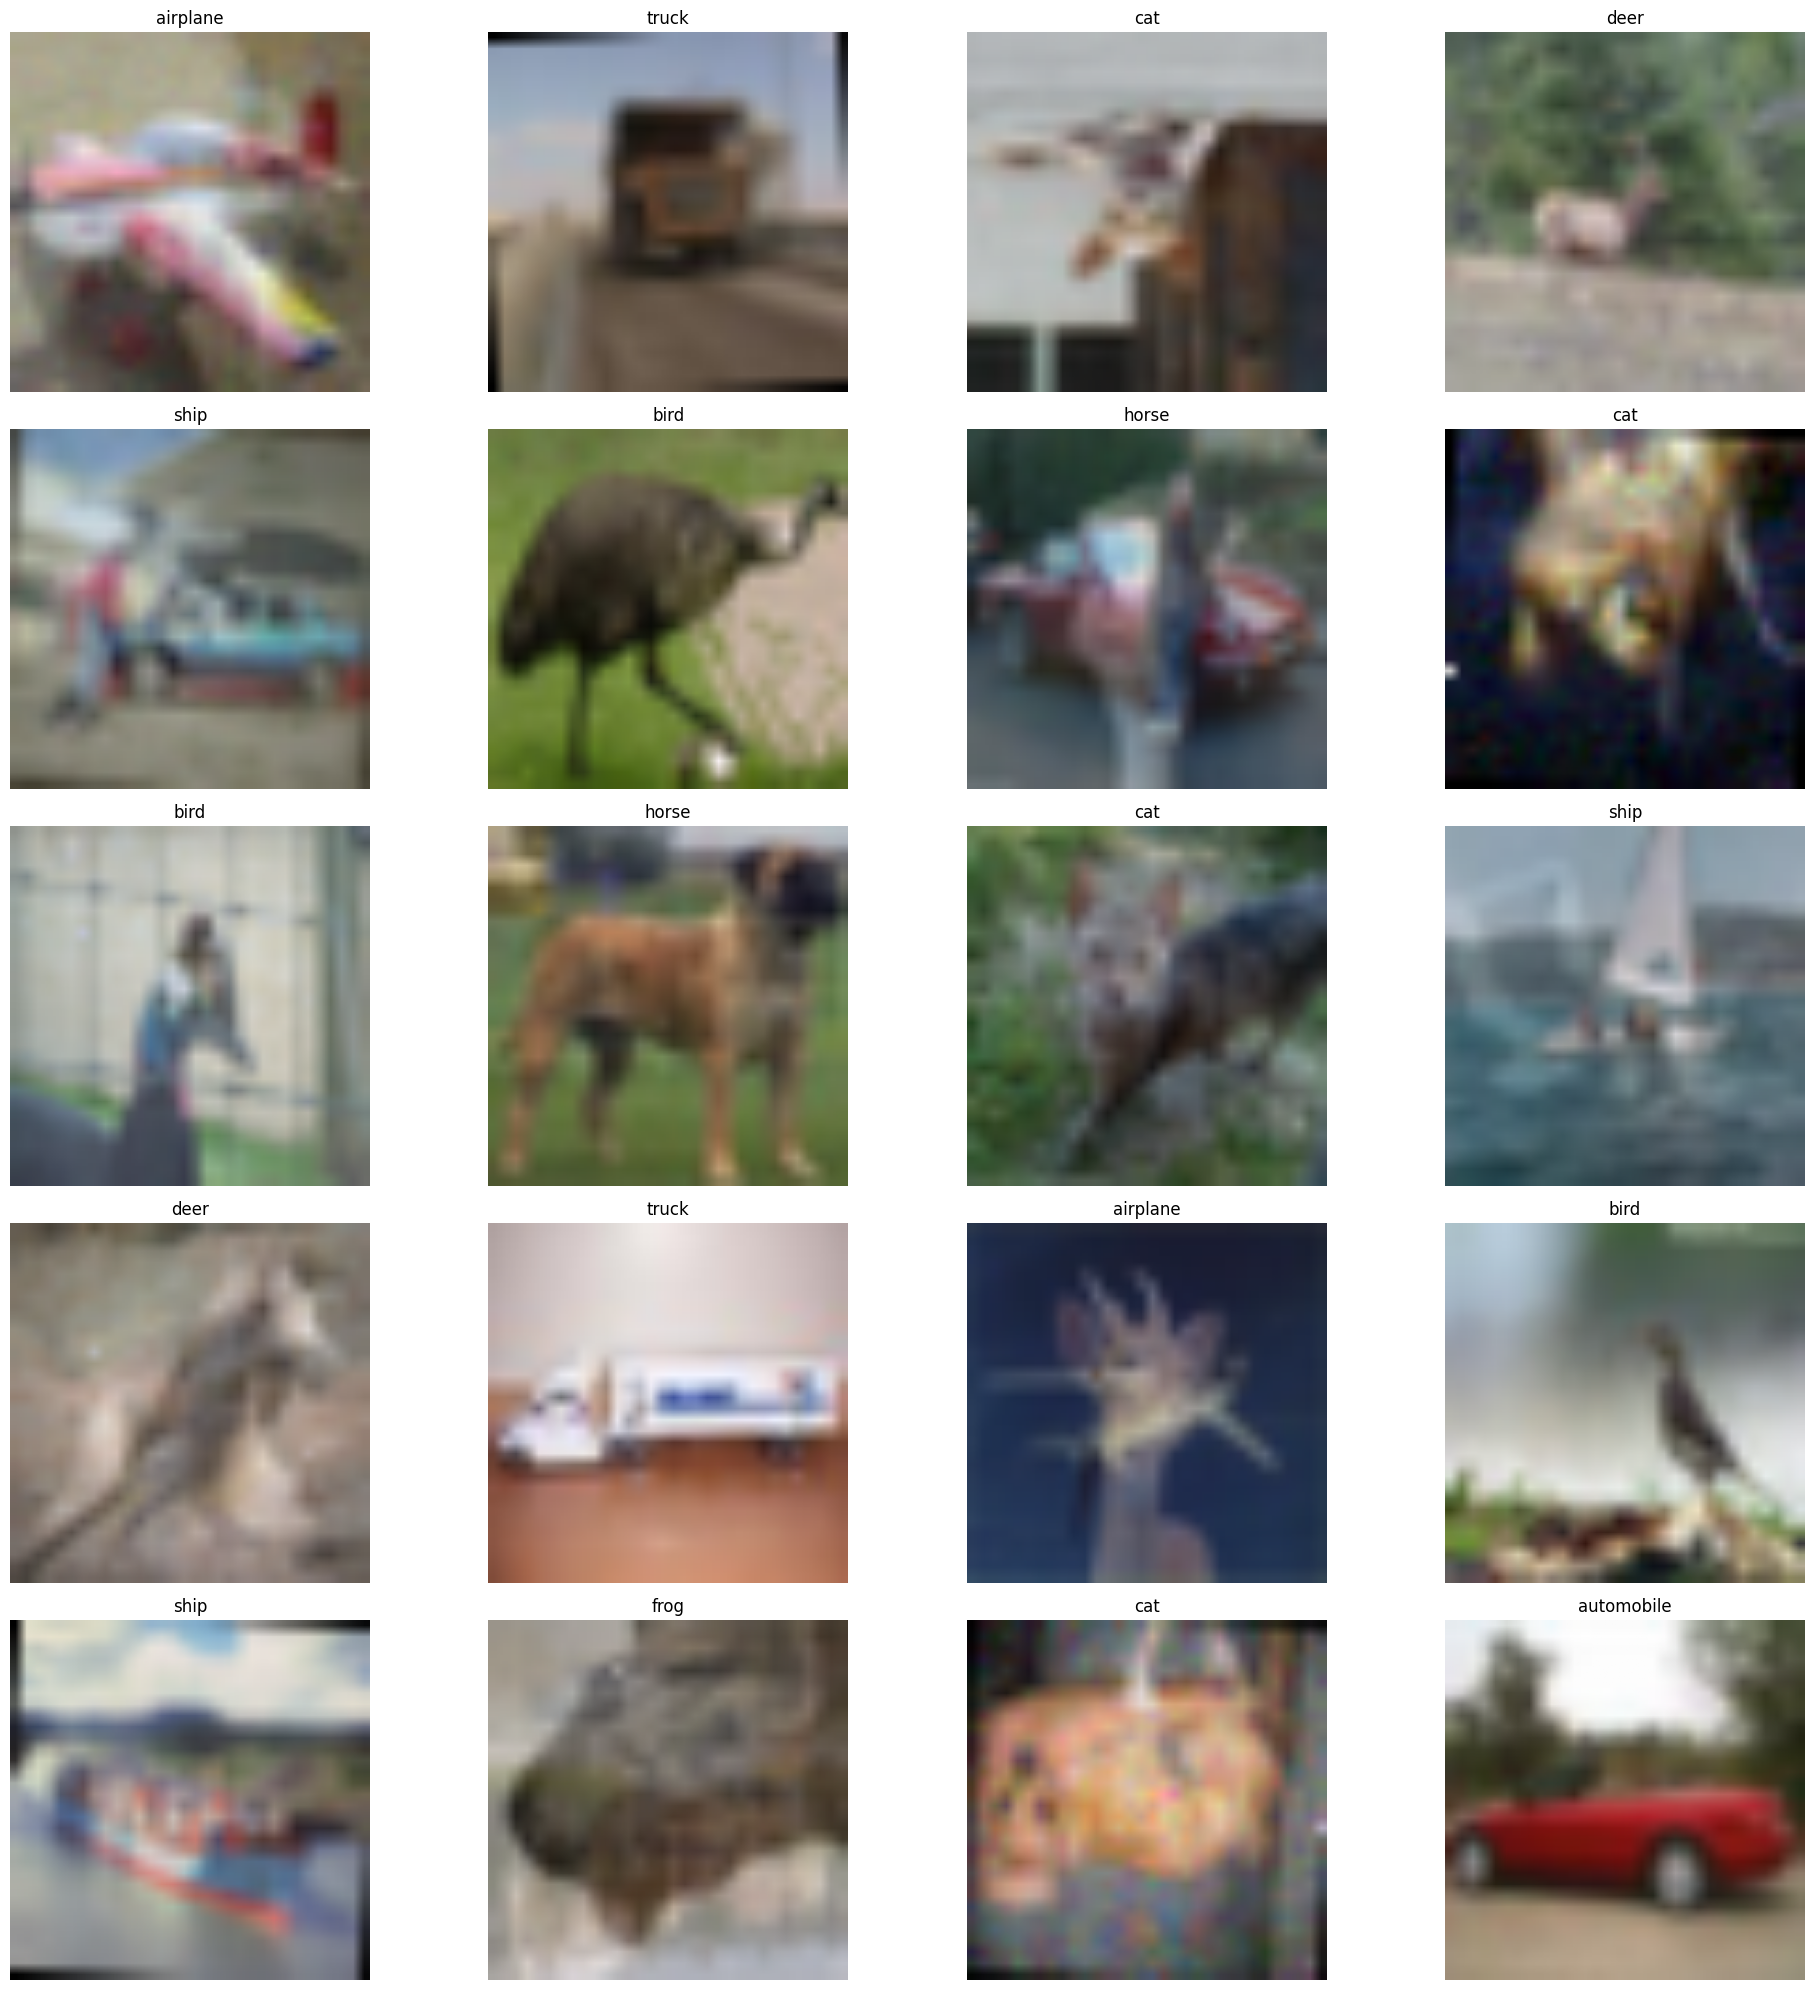

In [16]:
# Predict ramdom 20 images
import random
from torchvision.utils import make_grid
from PIL import Image

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




# choose 20 random images from test set
random_images = random.sample(image_files, 20)

fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.ravel()

# Perform inference and display images with predicted labels
for i, image_file in enumerate(random_images):
    # Open image
    image = Image.open(os.path.join(image_path, image_file))

    # Apply the same transformations as you did for your training images
    image_tensor = transform(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0).to(device)

    # Perform inference
    outputs = vgg16(image_tensor)
    _, predicted = torch.max(outputs, 1)

    # Display images with predicted labels
    image_tensor = image_tensor.cpu().numpy().transpose((0, 2, 3, 1))
    image_tensor = image_tensor.squeeze() * 0.5 + 0.5  # Un-normalize
    axs[i].imshow(image_tensor)
    axs[i].set_title(classes[predicted.item()])
    axs[i].axis('off')

plt.tight_layout()
plt.show()


Image: 1.png, Label: cat
Image: 2.png, Label: airplane
Image: 3.png, Label: automobile
Image: 4.png, Label: ship
Image: 5.png, Label: bird
Image: 6.png, Label: cat
Image: 7.png, Label: airplane
Image: 8.png, Label: cat
Image: 9.png, Label: bird
Image: 10.png, Label: frog
Image: 11.png, Label: bird
Image: 12.png, Label: deer
Image: 13.png, Label: bird
Image: 14.png, Label: truck
Image: 15.png, Label: dog
Image: 16.png, Label: airplane
Image: 17.png, Label: deer
Image: 18.png, Label: deer
Image: 19.png, Label: airplane
Image: 20.png, Label: deer


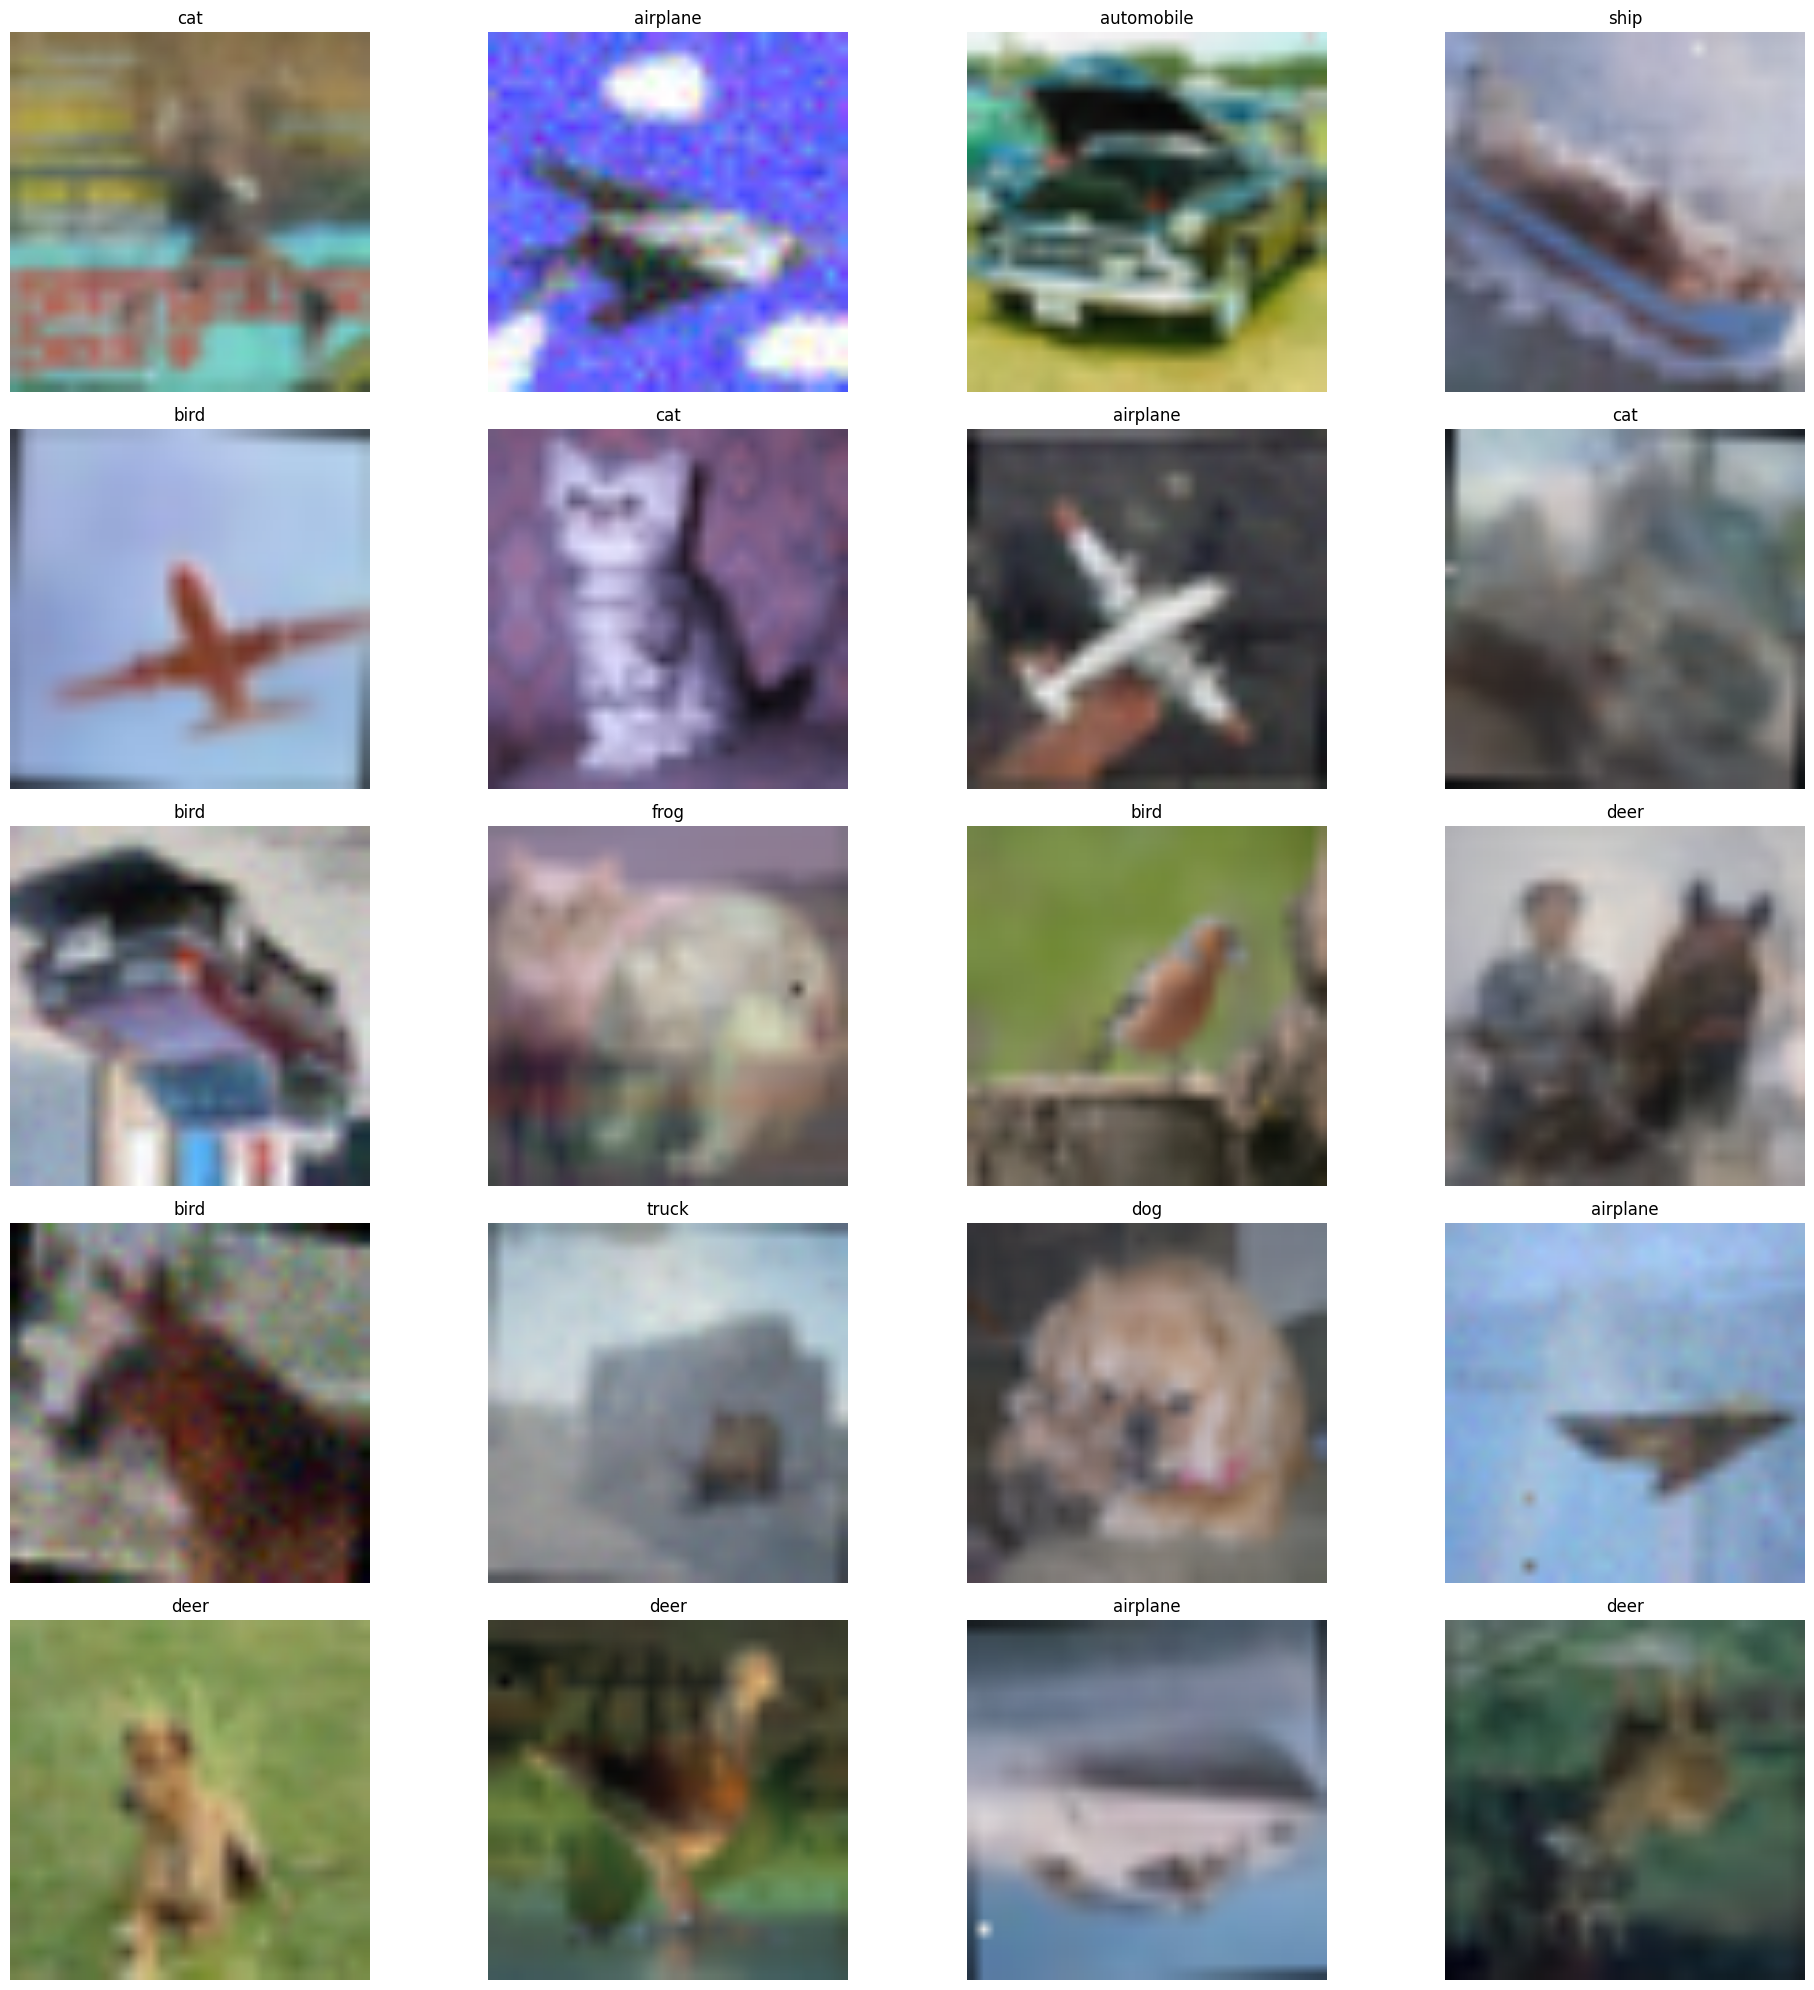

In [17]:
# Predict fist 20 images
import os
from torchvision.utils import make_grid

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define first 20 images from the dataset
image_files = [f"{i+1}.png" for i in range(20)]

fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.ravel()

# Perform inference and display images with predicted labels
for i, image_file in enumerate(image_files):
    # Open image
    image = Image.open(os.path.join(image_path, image_file))

    # Apply the same transformations as you did for your training images
    image_tensor = transform(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0).to(device)

    # Perform inference
    outputs = vgg16(image_tensor)
    _, predicted = torch.max(outputs, 1)

    # Print predicted labels
    print(f'Image: {image_file}, Label: {classes[predicted.item()]}')

    # Display images with predicted labels
    image_tensor = image_tensor.cpu().numpy().transpose((0, 2, 3, 1))
    image_tensor = image_tensor.squeeze() * 0.5 + 0.5  # Un-normalize
    axs[i].imshow(image_tensor)
    axs[i].set_title(classes[predicted.item()])
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [18]:

# Test to csv no batch

Temp_Skip =1

if Temp_Skip == 0:

    import os
    import pandas as pd
    import time
    from torchvision.utils import make_grid

    classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Define first 20 images from the dataset
    image_files = [f"{i+1}.png" for i in range(300000)]

    # Prepare to record the results
    results = []

    start_time = time.time()

    for i, image_file in enumerate(image_files):
        # Open image
        image = Image.open(os.path.join(image_path, image_file))

        # Apply the same transformations as you did for your training images
        image_tensor = transform(image).float()

        # Add an extra batch dimension since pytorch treats all images as batches
        image_tensor = image_tensor.unsqueeze_(0).to(device)

        # Perform inference
        outputs = vgg16(image_tensor)
        _, predicted = torch.max(outputs, 1)

        # Append to results
        results.append([image_file, classes[predicted.item()]])

        # Print time estimation
        elapsed_time = time.time() - start_time
        estimated_remaining_time = elapsed_time / (i + 1) * (len(image_files) - i - 1)
        print(f"Progress: {i+1}/{len(image_files)}, Estimated time left: {format_time(estimated_remaining_time)}",end='\r')

    # Save results to csv file
    df = pd.DataFrame(results, columns=['id', 'label'])
    df.to_csv('sampleSubmission.csv', index=False)

In [20]:
# NEW! Test to csv Batch

import os
import pandas as pd
import time
import torch
from torchvision.utils import make_grid

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define first 20 images from the dataset
image_files = [f"{i+1}.png" for i in range(300000)]

# Prepare to record the results
results = []

# Define your batch size. Be aware that a larger batch size requires more memory.
batch_size = 32

start_time = time.time()

num_batches = len(image_files) // batch_size + 1

print("Current deivce",device)

for b in range(num_batches):

    batch_files = image_files[b*batch_size: (b+1)*batch_size]

    if not batch_files:  # Skip the loop if there are no batch files
        continue

    batch_tensors = []
    for image_file in batch_files:
        # Open image
        image = Image.open(os.path.join(image_path, image_file))

        # Apply the same transformations as you did for your training images
        image_tensor = transform(image).float()

        # Add an extra batch dimension since pytorch treats all images as batches
        image_tensor = image_tensor.unsqueeze_(0).to(device)

        batch_tensors.append(image_tensor)

    # Concatenate all tensors in the batch
    batch_tensors = torch.cat(batch_tensors)

    # Perform inference
    outputs = vgg16(batch_tensors)
    _, predicted = torch.max(outputs, 1)

    # Append to results
    for i, image_file in enumerate(batch_files):
        results.append([image_file, classes[predicted[i].item()]])

    # Print time estimation
    elapsed_time = time.time() - start_time
    estimated_remaining_time = elapsed_time / (b + 1) * (num_batches - b - 1)
    print(f"Progress: {b+1}/{num_batches}, Estimated time left: {format_time(estimated_remaining_time)}", end='\r')


# Save results to csv file
df = pd.DataFrame(results, columns=['id', 'label'])
df.to_csv('sampleSubmission.csv', index=False)


Current deivce cuda


In [ ]:
## Test To csv using Batch
import os
import pandas as pd
from PIL import Image
from torch.autograd import Variable
import sys

#from tqdm import tqdm

# Class labels for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Prepare to record the results
results = []

#################### IMPORTANT set batch_size according to your gpu memory
## Set batch size
batch_size = 1  # Adjust this value according to your GPU memory (how much? IDK...)

# Prepare batches
num_batches = len(image_files) // batch_size + 1


start_time = time.time()

for b in range(num_batches):
    
    ## Time codes
    batch_start_time = time.time()
    batch_end_time = time.time()
    elapsed_time = batch_end_time - batch_start_time
    total_elapsed_time = batch_end_time - start_time
    avg_time_per_batch = total_elapsed_time / (b + 1)
    remaining_batches = num_batches - b - 1
    estimated_remaining_time = remaining_batches * avg_time_per_batch

    print(
        f"Progress: {b}/{num_batches}, "
        f"Estimated time left: {format_time(estimated_remaining_time)}", 
        end='\r'
    )

    ## Batch Codes
    # Prepare the batch
    batch = image_files[b*batch_size: (b+1)*batch_size]
    batch_tensors = []

    if batch:  # Add this line to avoid processing empty batches
        for image_file in batch:
            # Open image
            image = Image.open(os.path.join(image_path, image_file))

            # Apply the same transformations as you did for your training images
            image_tensor = transform(image).float()

            # Add an extra batch dimension since pytorch treats all images as batches
            image_tensor = image_tensor.unsqueeze_(0).to(device)

            batch_tensors.append(image_tensor)
    
        # Concatenate the batch
        batch_tensors = torch.cat(batch_tensors, dim=0).to(device)

        # Predict the classes of the images
        outputs = vgg16(batch_tensors)
        _, predicted = torch.max(outputs, 1)
    
        # for i, predict in enumerate(predicted):
        #     results.append([(b*batch_size)+i+1, classes[predict.item()]])
        for i, predict in enumerate(predicted):
            results.append([batch[i], classes[predict.item()]])



# Save results to csv file
df = pd.DataFrame(results, columns=['id', 'label'])
df.to_csv('sampleSubmission.csv', index=False) 

KeyboardInterrupt: 

In [ ]:
# Test To csv No Batch
import os
import pandas as pd
from PIL import Image
from torch.autograd import Variable
import sys

# Class labels for CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Prepare to record the results
results = []

# Prepare the images
for image_file in image_files:

    # Open image
    image = Image.open(os.path.join(image_path, image_file))

    # Apply the same transformations as you did for your training images
    image_tensor = transform(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0).to(device)

    # Predict the class of the image
    output = vgg16(image_tensor)
    _, predicted = torch.max(output, 1)

    results.append([image_file, classes[predicted.item()]])

# Save results to csv file
df = pd.DataFrame(results, columns=['id', 'label'])
df.to_csv('sampleSubmission.csv', index=False)


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: './test/test\\1.png.png'

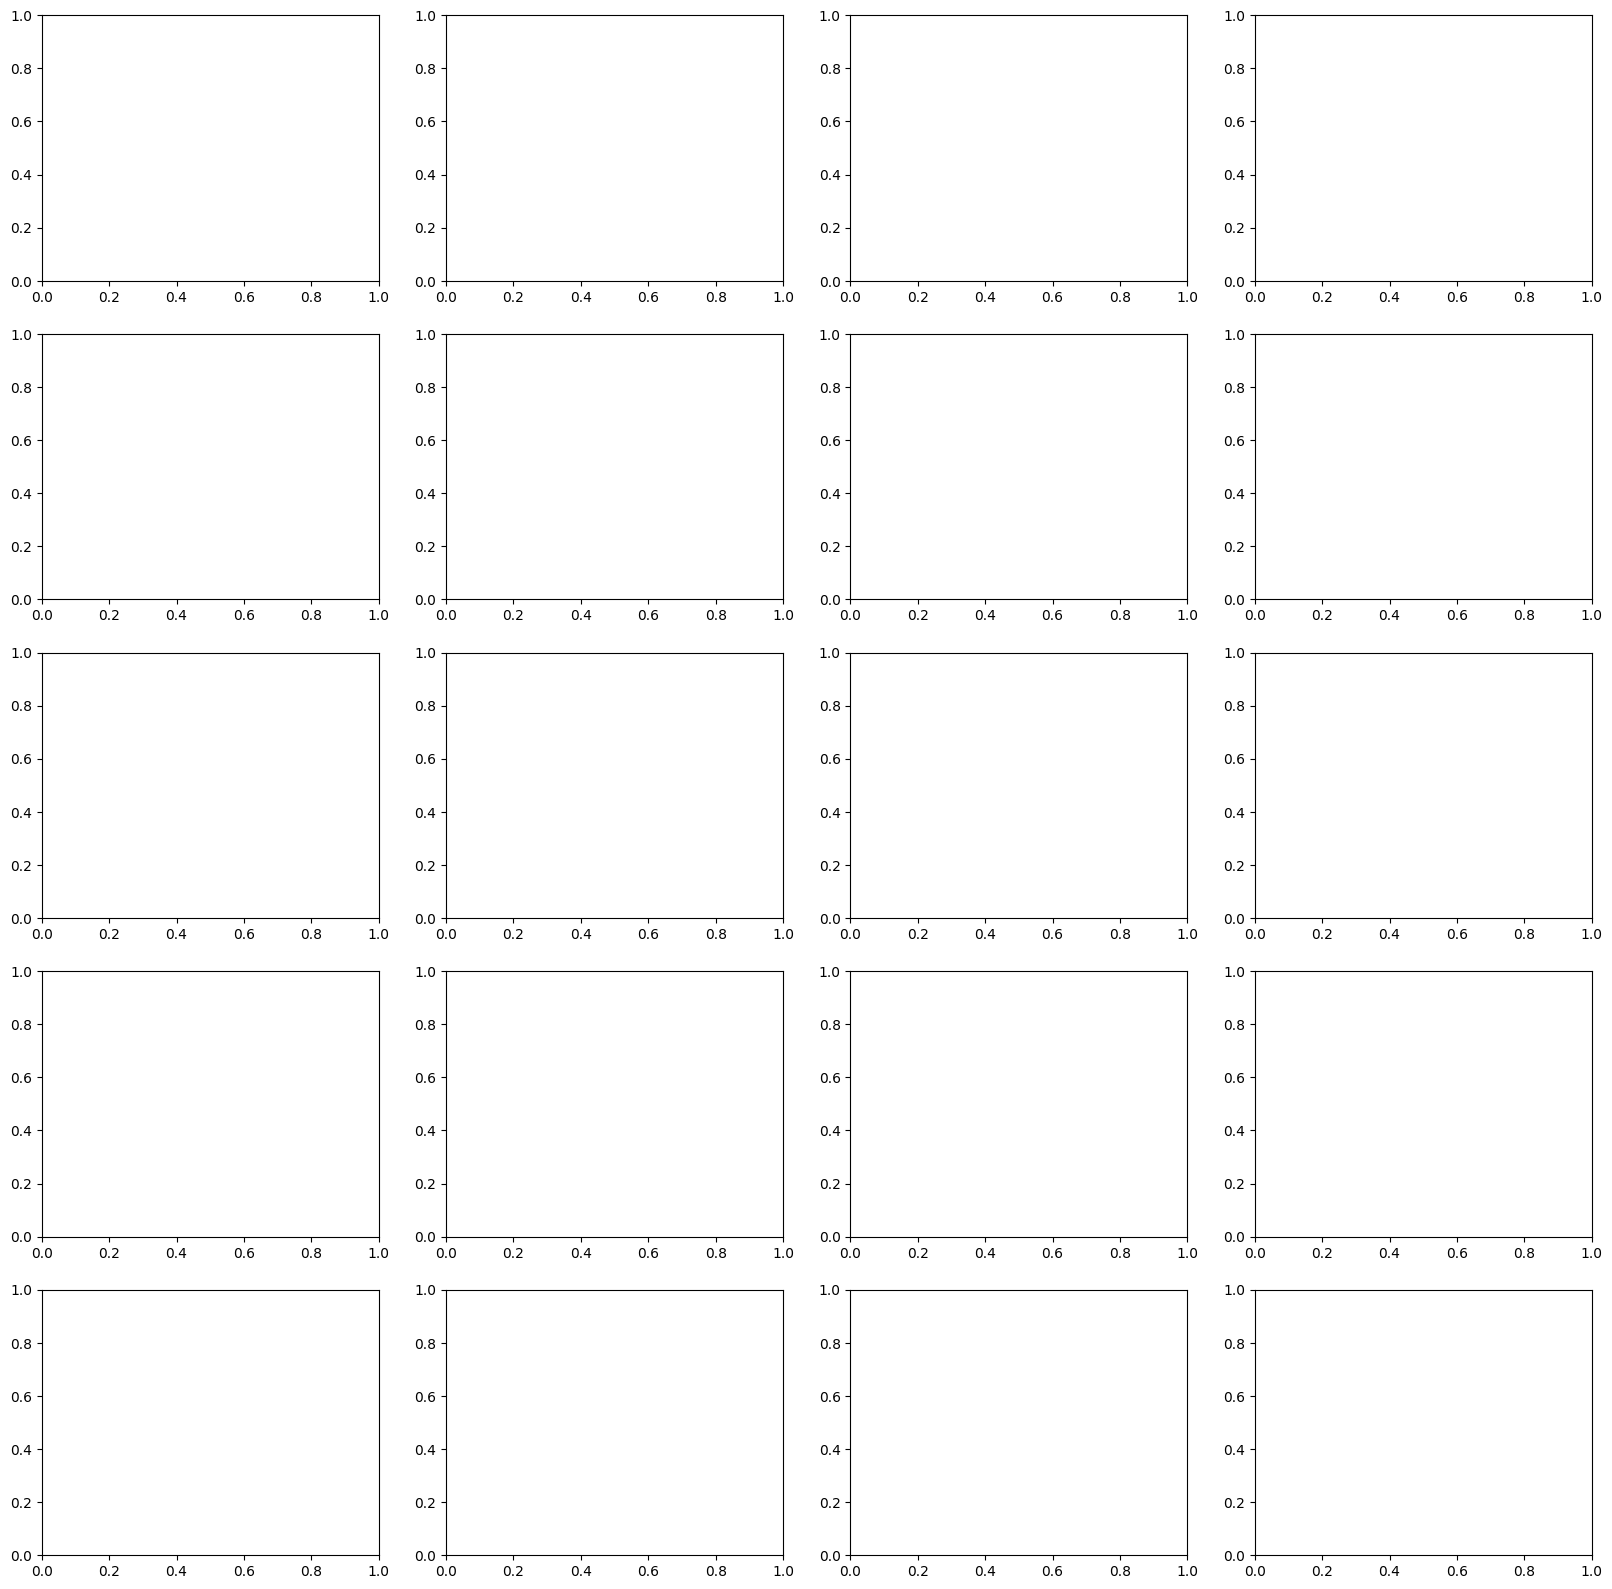

In [ ]:
import matplotlib.pyplot as plt

# Load the csv file
df = pd.DataFrame(pd.read_csv('sampleSubmission.csv'))

# Fetch the first 20 rows
first_20_images = df.head(20)

# Create a figure to display the images
fig, axs = plt.subplots(5, 4, figsize=(20, 20)) # 5 rows, 4 columns
axs = axs.ravel()

# Loop over the first 20 rows and display the images
for i, row in enumerate(first_20_images.itertuples()):
    image_file = os.path.join(image_path, f"{row.id}.png")  # Assuming the images are in .png format
    image = Image.open(image_file)
    axs[i].imshow(image)
    axs[i].set_title(row.label)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
csv = pd.read_csv('sampleSubmission.csv')
print(csv.shape)

(300000, 2)


In [ ]:
# import os
# import pandas as pd
# from PIL import Image
# from torch.autograd import Variable
# from tqdm import tqdm

# # Class labels for CIFAR-10
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# # Load trained VGG16 model
# # ... (This part is in your original code)

# # Load the pre-trained weights
# model_checkpoint = "vgg16CIFAR.pth"
# vgg16.load_state_dict(torch.load(model_checkpoint))

# # Make sure to do this before inference
# vgg16.eval()
# vgg16.to(device)

# # Path to your new images
# image_path = './test/test/'
# image_files = os.listdir(image_path)

# # Prepare to record the results
# results = []

# # Process each image one by one (You can modify this part to batch processing)
# for i, image_file in tqdm(enumerate(image_files)):
#     # Open image
#     image = Image.open(os.path.join(image_path, image_file))

#     # Apply the same transformations as you did for your training images
#     image_tensor = transform(image).float()

#     # Add an extra batch dimension since pytorch treats all images as batches
#     image_tensor = image_tensor.unsqueeze_(0)

#     # Move the tensor to GPU if available
#     image_tensor = image_tensor.to(device)

#     # Turn the input into a Variable
#     input = Variable(image_tensor)

#     # Predict the class of the image
#     output = vgg16(input)
#     _, predicted = torch.max(output, 1)
#     results.append([i+1, classes[predicted.item()]])


# # Save results to csv file
# df = pd.DataFrame(results, columns=['id', 'label'])
# df.to_csv('sampleSubmission.csv', index=False)

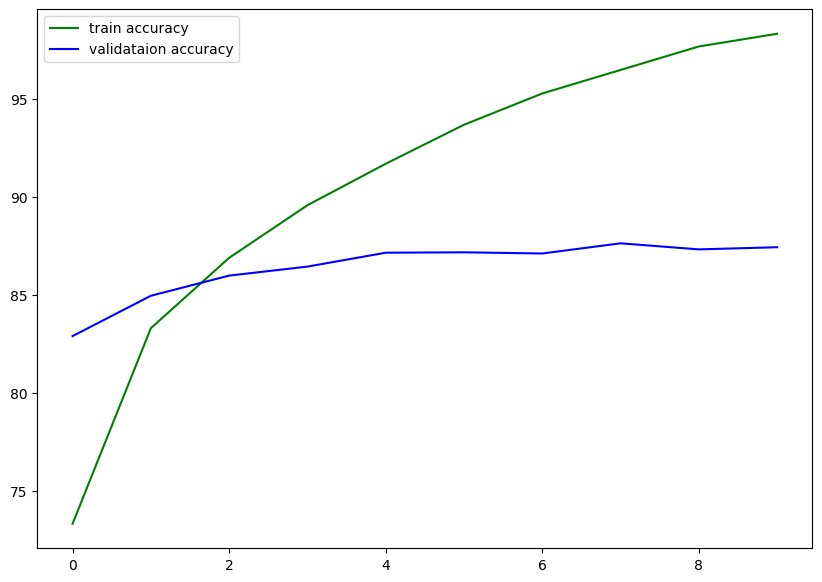

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

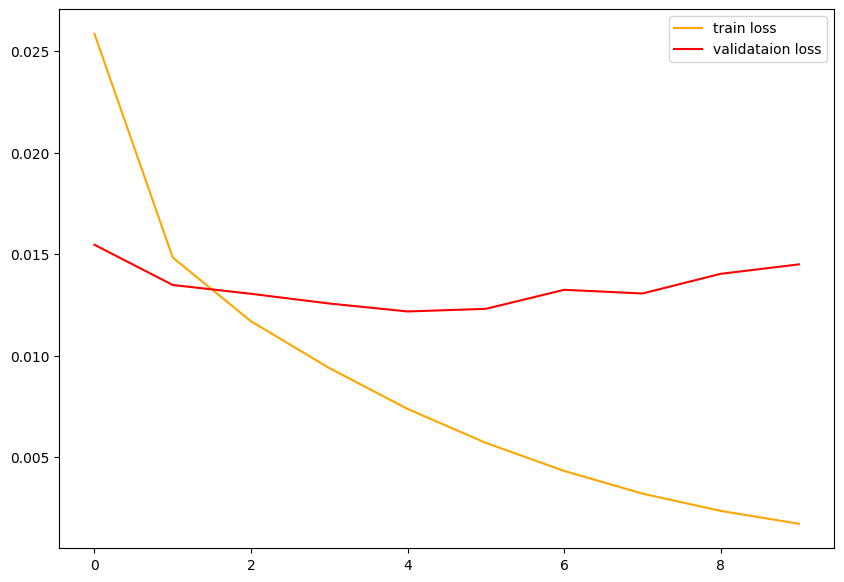

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()